## 

Initial thoughts/questions
Does the lot size affect the value of the house?
Does the county a home is located in affect the value of the home?
Does the age of a home affect the value of the home?

Counties by FIP:
    6037 - Los Angeles County
    6059 - Orange County
    6111 - Ventura County
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from scipy import stats


import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Import created modules
import env
import acquire
import wrangle_zillow

# Clear pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# Handle large numbers w/o using scientific notation
pd.options.display.float_format = '{:.3f}'.format

### ```Acquire & Prepare Data```

In [2]:
df = wrangle_zillow.acquire('zillow')
df.head()

,bathroomcnt,bedroomcnt,yearbuilt,calculatedfinishedsquarefeet,lotsizesquarefeet,parcelid,fips,regionidzip,taxvaluedollarcnt,taxamount
0,2.000,3.000,1923.000,1316.000,5672.000,11721753,6037.000,95997.000,205123.000,2627.480
1,2.000,3.000,1970.000,1458.000,8284.000,11289917,6037.000,97318.000,136104.000,2319.900
2,2.000,3.000,1980.000,1766.000,25082.000,11637029,6037.000,96086.000,810694.000,9407.010
3,3.000,4.000,2003.000,2541.000,4975.000,14269464,6059.000,96958.000,880456.000,9819.720
4,2.000,3.000,1955.000,1491.000,5000.000,11446756,6037.000,96162.000,107110.000,1399.270


In [3]:
print(f'My original dataframe is coming in with {df.shape[0]} rows and {df.shape[ 1]} columns.')

My original dataframe is coming in with 30259 rows and 10 columns.


Takeaways on data pulled in from SQL: 
    
- Pulled in data for the months of 5/1/2017 - 8/31/2017.

- Only properties with a unit count of 1, which includes Single Family Residence, Rural Residence, Mobile Home, Town House, Bungalow, Zero Lot Line, Patio Home and Inferred Single Family Residential 
- Initial exploration revealed outliers, so the acquire query was adjusted as follows:
- Only square footages from 700 - 5500
- Assessed with tax values between 90,000 and 3,100,000
- 1-8 bedrooms and 1-7 baths

Initial review of the data within Sequel revealed: 
    
- bathroomcnt, bedroomcnt, fips, parcelid have no nulls
- 10,550 of buildingqualitytypeid are null, so I will remove this feature.  
- Replace it with yearbuilt - which has 83 nulls
- calculatedfinishedsquarefeet had 60 nulls
- lotsizesquarefeet has 663 nulls
- regionidzip has 22 nulls
    
    

### ```Prepare Data```

In [4]:
df = wrangle_zillow.prep_zillow(df)
df.head()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes
parcel_id,,,,,,,,,
11721753,2,3,94,1316,5672.000,6037,95997,205123.000,2627.480
11289917,2,3,47,1458,8284.000,6037,97318,136104.000,2319.900
11637029,2,3,37,1766,25082.000,6037,96086,810694.000,9407.010
14269464,3,4,14,2541,4975.000,6059,96958,880456.000,9819.720
11446756,2,3,62,1491,5000.000,6037,96162,107110.000,1399.270


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30259 entries, 11721753 to 10713993
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathrooms    30259 non-null  int64  
 1   bedrooms     30259 non-null  int64  
 2   age          30259 non-null  int64  
 3   square_feet  30259 non-null  int64  
 4   lot_size     30259 non-null  float64
 5   fips         30259 non-null  int64  
 6   zip_code     30259 non-null  int64  
 7   tax_value    30259 non-null  float64
 8   taxes        30259 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 2.3 MB


In [6]:
df.shape

(30259, 9)

In [7]:
df.columns

Index(['bathrooms', 'bedrooms', 'age', 'square_feet', 'lot_size', 'fips',
       'zip_code', 'tax_value', 'taxes'],
      dtype='object')

In [8]:
df.describe()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes
count,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000
mean,2.309,3.167,48.126,1843.995,30609.348,6047.488,96524.673,506419.954,6183.252
std,0.865,0.947,22.481,811.673,114494.717,20.048,404.214,399716.440,4651.652
min,1.000,1.000,1.000,700.000,236.000,6037.000,95982.000,90035.000,62.440
25%,2.000,3.000,31.000,1254.000,5854.500,6037.000,96204.000,248916.000,3256.365
50%,2.000,3.000,48.000,1638.000,7380.000,6037.000,96383.000,400941.000,4944.940
75%,3.000,4.000,63.000,2240.000,12455.500,6059.000,96982.000,624139.000,7460.365
max,6.000,7.000,139.000,5496.000,6971010.000,6111.000,97344.000,3100000.000,61992.630


In [9]:
#I see an error in zipcodes -- the max value is six digits
zip_check = pd.DataFrame(df.zip_code > 99999)
zip_check.value_counts("zip_code")

zip_wrong = pd.DataFrame(df.zip_code == True)
zip_wrong                         
               


,zip_code
parcel_id,
11721753,False
11289917,False
11637029,False
14269464,False
11446756,False
...,...
14453399,False
12019061,False
11570288,False


In [10]:
df.isna().sum() 

bathrooms      0
bedrooms       0
age            0
square_feet    0
lot_size       0
fips           0
zip_code       0
tax_value      0
taxes          0
dtype: int64

In [11]:
df.bathrooms.value_counts(dropna=False)

2    14773
3     8819
1     4492
4     1613
5      464
6       98
Name: bathrooms, dtype: int64

In [12]:
df.bedrooms.value_counts(dropna=False)

3    12747
4     8043
2     6534
5     1983
1      659
6      264
7       29
Name: bedrooms, dtype: int64

In [13]:
df.age.value_counts(dropna=False)

62     813
53     739
67     694
28     673
64     636
      ... 
1        1
137      1
123      1
139      1
125      1
Name: age, Length: 131, dtype: int64

In [14]:
df.square_feet.value_counts(dropna=False)

1120    69
1200    65
1300    52
1080    52
864     50
        ..
3381     1
3629     1
3677     1
3693     1
4038     1
Name: square_feet, Length: 3639, dtype: int64

In [15]:
df.lot_size.value_counts(dropna=False)

6000.000      400
5000.000      212
7200.000      156
7000.000      145
6500.000      135
             ... 
9493.000        1
12551.000       1
193023.000      1
1360.000        1
8028.000        1
Name: lot_size, Length: 12729, dtype: int64

In [16]:
df.fips.value_counts(dropna=False)

6037    21060
6059     6988
6111     2211
Name: fips, dtype: int64

In [17]:
df.zip_code.value_counts(dropna=False)

97319    404
97329    293
97118    281
97318    276
96987    264
        ... 
95995      2
96226      2
95994      1
96039      1
96467      1
Name: zip_code, Length: 382, dtype: int64

In [18]:
df.tax_value.value_counts(dropna=False)


420000.000    22
550000.000    22
450000.000    19
430000.000    18
455000.000    18
              ..
511163.000     1
338187.000     1
144518.000     1
225691.000     1
229579.000     1
Name: tax_value, Length: 22807, dtype: int64

In [19]:
df.tax_value

parcel_id
11721753    205123.000
11289917    136104.000
11637029    810694.000
14269464    880456.000
11446756    107110.000
               ...    
14453399    852813.000
12019061    492395.000
11570288    600608.000
11128688   1120000.000
10713993    563463.000
Name: tax_value, Length: 30259, dtype: float64

In [20]:
q1, q3 = df.tax_value.quantile([.25, .75])

iqr = q3 - q1

In [21]:
q1

248916.0

In [22]:
q3

624139.0

In [23]:
df.taxes.value_counts(dropna=False)

3297.910    3
1421.540    3
2839.260    3
3509.140    3
2880.860    2
           ..
3971.710    1
5001.410    1
6475.980    1
5150.300    1
5632.000    1
Name: taxes, Length: 29703, dtype: int64

### ```Split Data```

In [24]:
 print(f'My original dataframe is coming in with {df.shape[0]} rows and {df.shape[ 1]} columns.')

My original dataframe is coming in with 30259 rows and 9 columns.


In [25]:
# Data is split into X_ and y_ train, test and validate data sets

X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle_zillow.train_validate_test_split(df, 'tax_value')

In [26]:
X_train.shape, X_validate.shape, X_test.shape

((16944, 8), (7263, 8), (6052, 8))

In [27]:
y_train.shape, y_validate.shape, y_test.shape

((16944,), (7263,), (6052,))

In [28]:
X_train.head()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,taxes
parcel_id,,,,,,,,
11640078,6,4,65,3614,25587.000,6037,96086,5662.800
10728405,2,3,57,1466,8149.000,6037,96342,7435.650
17239776,2,3,53,1623,8300.000,6111,97116,6278.580
11473641,2,3,74,1624,6544.000,6037,96103,1395.380
12551066,2,3,64,1286,3268.000,6037,96245,2955.920


In [29]:
y_train.head()

parcel_id
11640078   475281.000
10728405   605000.000
17239776   542864.000
11473641   120656.000
12551066   234048.000
Name: tax_value, dtype: float64

In [30]:
#Creating dataframes for target variable sets

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
y_train.head(2)

,tax_value
parcel_id,
11640078,475281.000
10728405,605000.000


In [31]:
y_validate.head(2)

,tax_value
parcel_id,
11344899,568000.000
11855831,329844.000


In [32]:
y_test.head(2)

,tax_value
parcel_id,
14383004,673097.000
12121210,179190.000


### ```Scale Data```

In [33]:
# Scale the data using MinMaxScaler function

num_cols = ['bedrooms','bathrooms','age','square_feet', 'lot_size','zip_code', 'taxes', 'fips']
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle_zillow.min_max_scale(X_train, X_validate, X_test, num_cols)

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((16944, 8), (7263, 8), (6052, 8))

### ```Explore Data```

array([[<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'square_feet'}>,
        <AxesSubplot:title={'center':'lot_size'}>,
        <AxesSubplot:title={'center':'fips'}>],
       [<AxesSubplot:title={'center':'zip_code'}>,
        <AxesSubplot:title={'center':'tax_value'}>,
        <AxesSubplot:title={'center':'taxes'}>]], dtype=object)

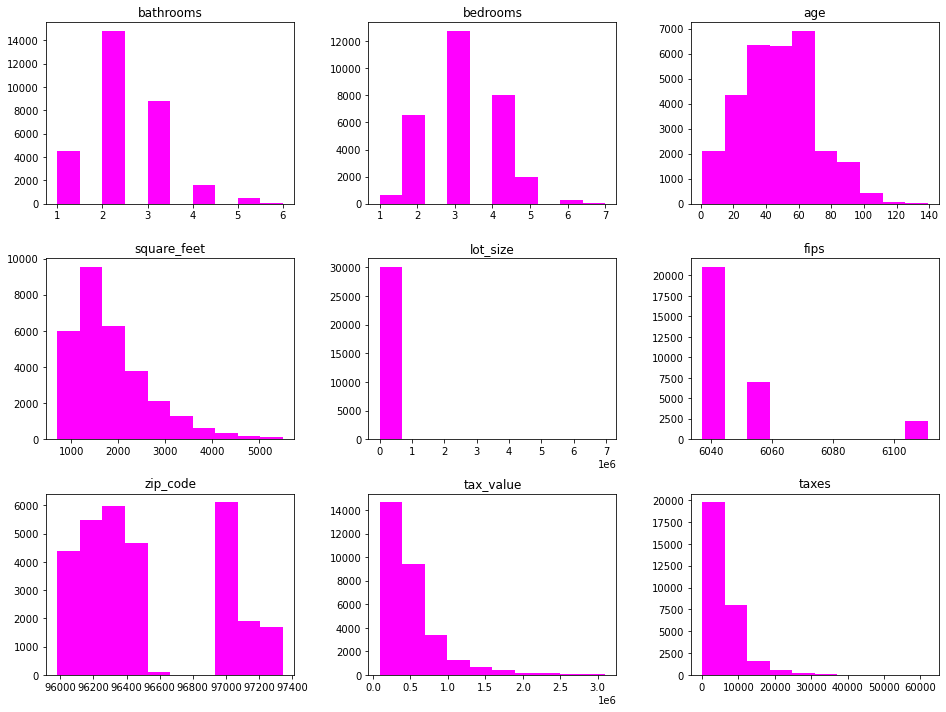

In [34]:
#Exploring distribution of all numeric columns in entire df

df.hist(grid=False, figsize=(16,12), color='magenta')

<AxesSubplot:xlabel='fips', ylabel='Density'>

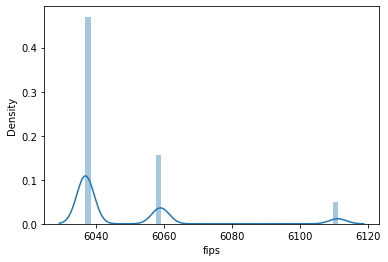

In [35]:
#Create a distplot to explore the distribution of Pandas Series

sns.distplot(df.fips)

<AxesSubplot:>

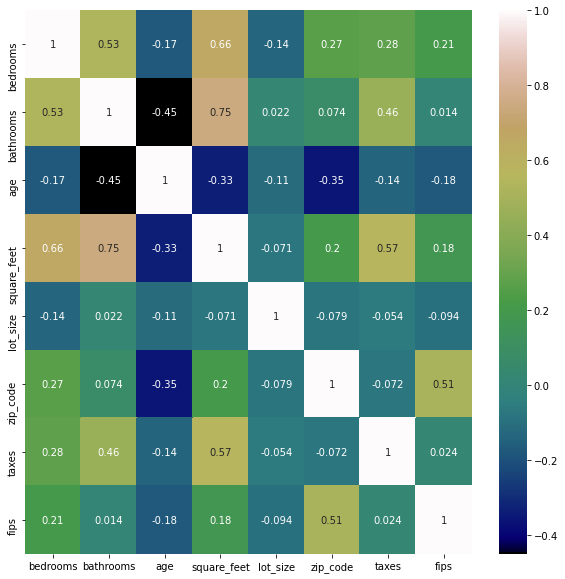

In [36]:

plt.subplots(figsize=(10,10))
sns.heatmap(X_train_scaled.corr(), cmap='gist_earth',annot=True)

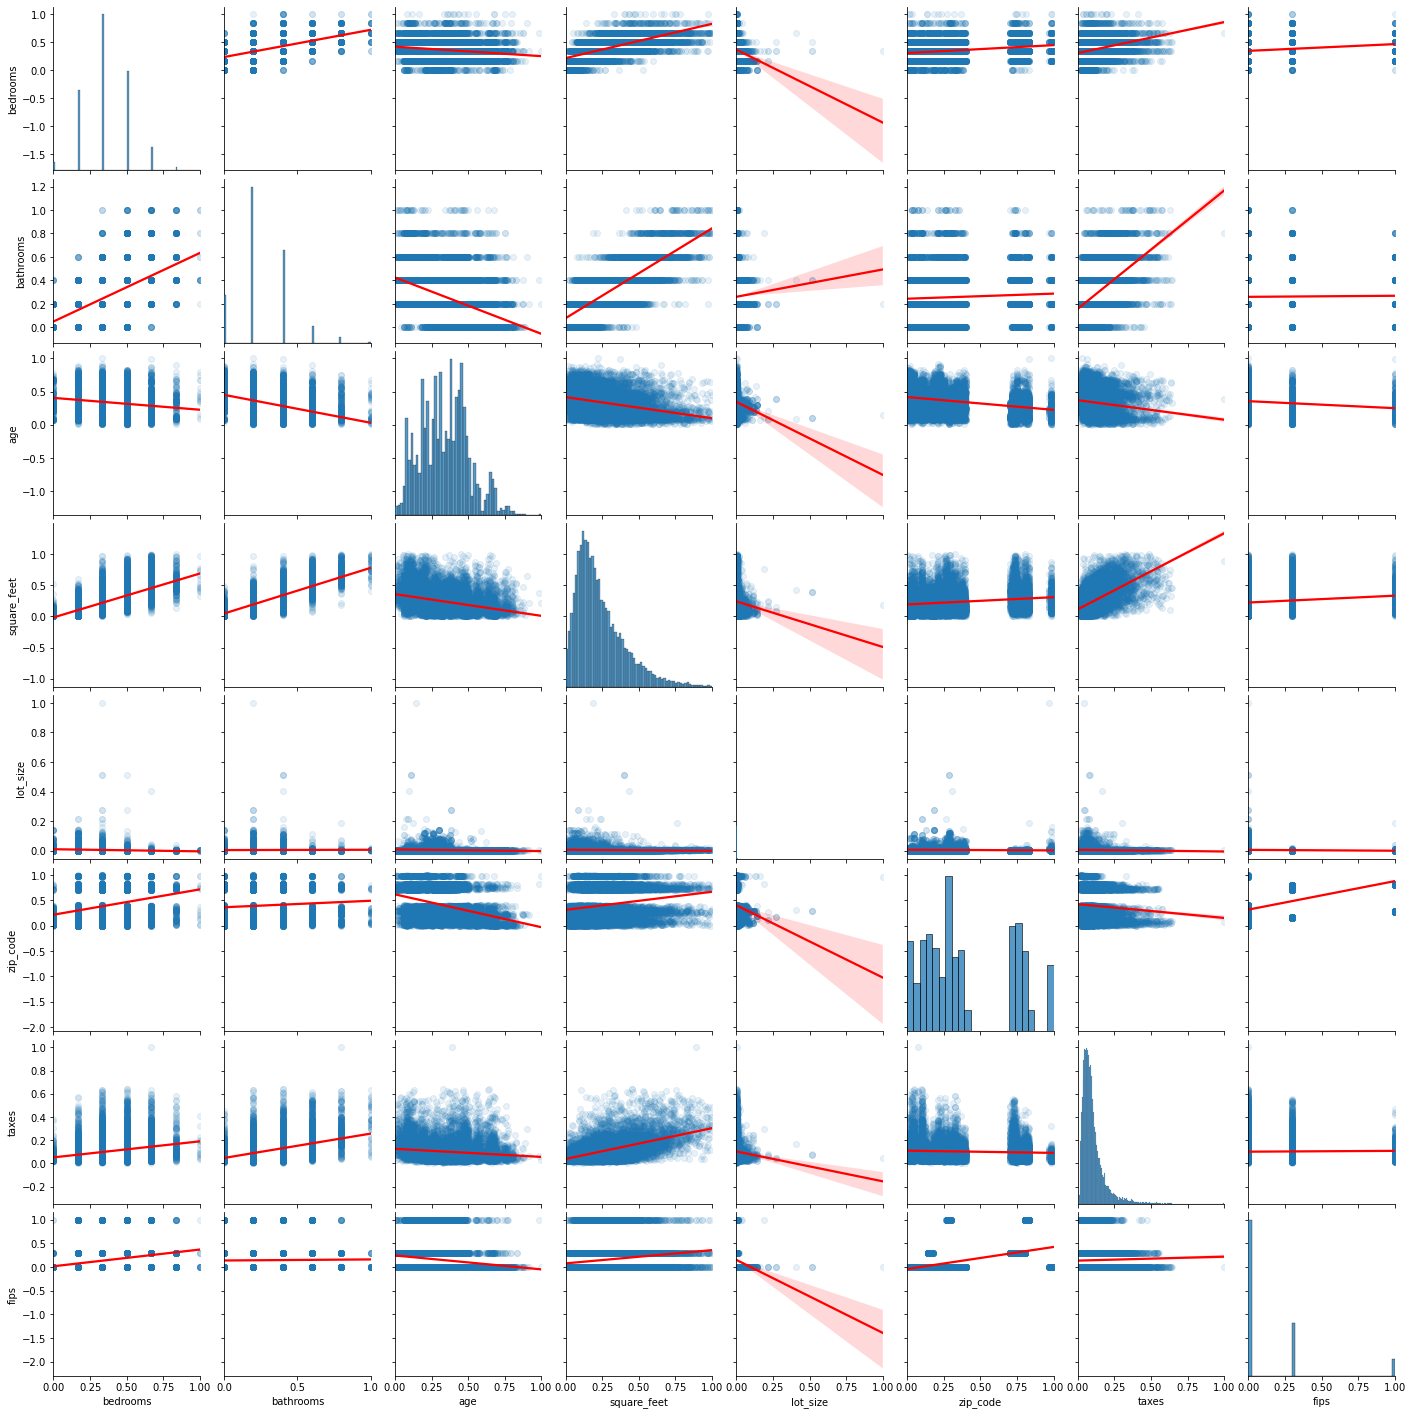

In [37]:
plot_kws={'line_kws':{'color':'red'},'scatter_kws': {'alpha': 0.7}}    
sns.pairplot(X_train_scaled, kind="reg", plot_kws={'line_kws':{'color':'red'},'scatter_kws': {'alpha': 0.1} })


The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.53


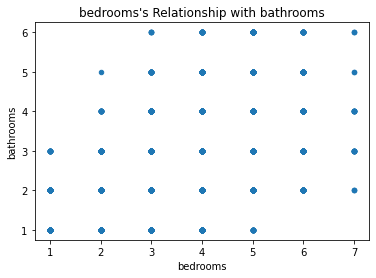

In [38]:
def correlation_exploration(train, x_string, y_string):
    '''
    This function takes in a df, a string for an x-axis variable in the df, 
    and a string for a y-axis variable in the df and displays a scatter plot, the r-
    squared value, and the p-value. It explores the correlation between input the x 
    and y variables.
    '''
    r, p = stats.pearsonr(train[x_string], train[y_string])
    df.plot.scatter(x_string, y_string)
    plt.title(f"{x_string}'s Relationship with {y_string}")
    print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
    print(f'r = {round(r, 2)}')
    plt.show()
    
correlation_exploration(X_train_scaled, 'bedrooms', 'bathrooms')

The p-value is: 2.6491141113499226e-294. There is 0.0% chance that we see these results by chance.
r = 0.28


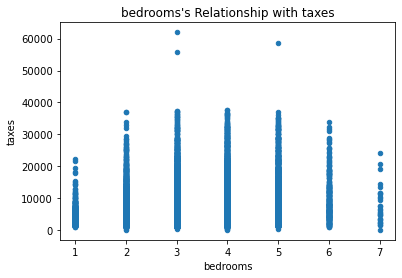

In [39]:
correlation_exploration(X_train, 'bedrooms', 'taxes')

The p-value is: 3.739425368089971e-21. There is 0.0% chance that we see these results by chance.
r = -0.07


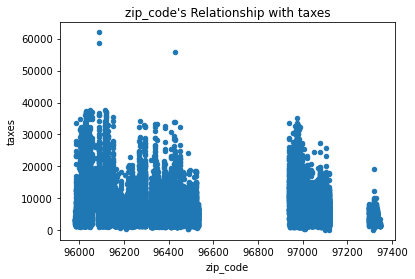

In [40]:
correlation_exploration(X_train, 'zip_code', 'taxes')

The p-value is: 0.0015609357743409356. There is 0.002% chance that we see these results by chance.
r = 0.02


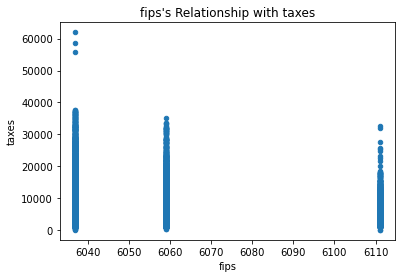

In [41]:
correlation_exploration(X_train, 'fips', 'taxes')

The p-value is: 1.3282308202057336e-78. There is 0.0% chance that we see these results by chance.
r = -0.14


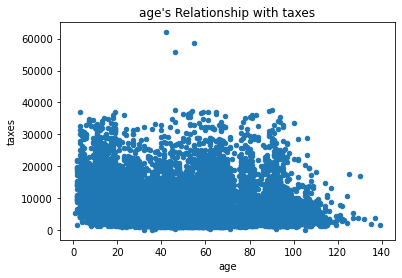

In [42]:
correlation_exploration(X_train, 'age', 'taxes')

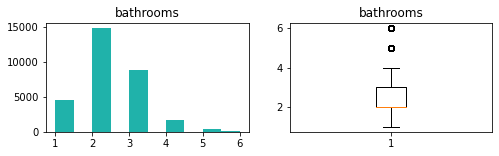

count   30259.000
mean        2.309
std         0.865
min         1.000
25%         2.000
50%         2.000
75%         3.000
max         6.000
Name: bathrooms, dtype: float64


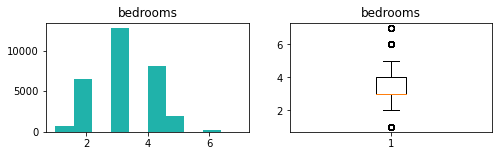

count   30259.000
mean        3.167
std         0.947
min         1.000
25%         3.000
50%         3.000
75%         4.000
max         7.000
Name: bedrooms, dtype: float64


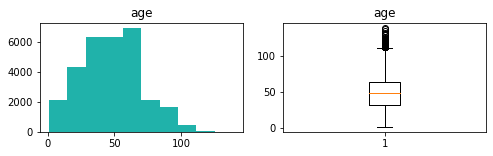

count   30259.000
mean       48.126
std        22.481
min         1.000
25%        31.000
50%        48.000
75%        63.000
max       139.000
Name: age, dtype: float64


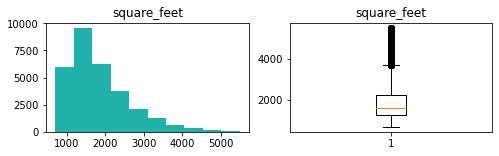

count   30259.000
mean     1843.995
std       811.673
min       700.000
25%      1254.000
50%      1638.000
75%      2240.000
max      5496.000
Name: square_feet, dtype: float64


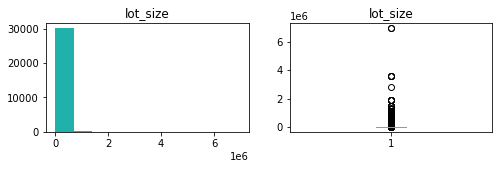

count     30259.000
mean      30609.348
std      114494.717
min         236.000
25%        5854.500
50%        7380.000
75%       12455.500
max     6971010.000
Name: lot_size, dtype: float64


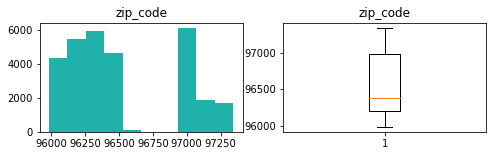

count   30259.000
mean    96524.673
std       404.214
min     95982.000
25%     96204.000
50%     96383.000
75%     96982.000
max     97344.000
Name: zip_code, dtype: float64


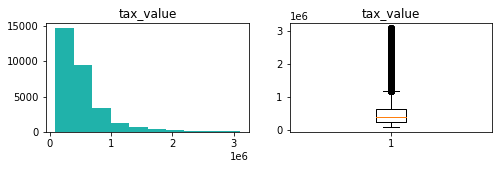

count     30259.000
mean     506419.954
std      399716.440
min       90035.000
25%      248916.000
50%      400941.000
75%      624139.000
max     3100000.000
Name: tax_value, dtype: float64


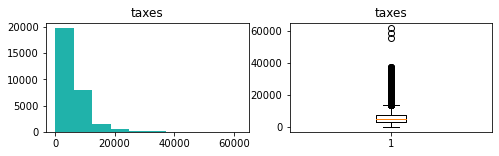

count   30259.000
mean     6183.252
std      4651.652
min        62.440
25%      3256.365
50%      4944.940
75%      7460.365
max     61992.630
Name: taxes, dtype: float64


In [43]:
# def plot_cat_by_target(train, target, cat_var):
#     p = plt.figure(figsize=(8,8))
#     p = sns.barplot(cat_var, target, data=train, alpha=.8, color='lightseagreen')
#     overall_rate = train[target].mean()
#     p = plt.axhline(overall_rate, ls='--', color='gray')
#     return p 

# plot_cat_by_target(df, df.tax_value, df.bedrooms)
cat_vars = []
quant_vars = ['bathrooms', 'bedrooms', 'age', 'square_feet', 'lot_size', 'zip_code', 'tax_value', 'taxes']
def explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='lightseagreen')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats

def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)
        
explore_univariate(df, cat_vars, quant_vars)

In [45]:
df.age.value_counts(bins=50, sort=False)

(0.861, 3.76]         96
(3.76, 6.52]         151
(6.52, 9.28]         183
(9.28, 12.04]       1022
(12.04, 14.8]        666
(14.8, 17.56]        938
(17.56, 20.32]       820
(20.32, 23.08]       664
(23.08, 25.84]       450
(25.84, 28.6]       1461
(28.6, 31.36]       1496
(31.36, 34.12]      1118
(34.12, 36.88]       747
(36.88, 39.64]      1610
(39.64, 42.4]       1361
(42.4, 45.16]       1563
(45.16, 47.92]       745
(47.92, 50.68]       952
(50.68, 53.44]      1632
(53.44, 56.2]       1411
(56.2, 58.96]        915
(58.96, 61.72]      1392
(61.72, 64.48]      2053
(64.48, 67.24]      1704
(67.24, 70.0]       1241
(70.0, 72.76]        232
(72.76, 75.52]       356
(75.52, 78.28]       672
(78.28, 81.04]       372
(81.04, 83.8]         80
(83.8, 86.56]        119
(86.56, 89.32]       336
(89.32, 92.08]       509
(92.08, 94.84]       385
(94.84, 97.6]        304
(97.6, 100.36]        77
(100.36, 103.12]      85
(103.12, 105.88]      82
(105.88, 108.64]     117
(108.64, 111.4]       61


### ```Hypothesis Testing - Correlation #1 - County/Tax Value: ```
    
#### Does the county a home is located in affect the tax value?

- H$_{0}$: There is no relationship between the county is located in and its tax value.  --> <font color = 'red'> **REJECTED**<font color = 'black'>

- H$_{a}$: There is a dependent relationship between county and tax value.  

#### Takeaways: 
- The 'r' correlation coefficient is 0.06468945085502781
- The p-value (probability of seeing the data given the null hypothesis is true) is  3.492977794581021e-17

**Therefore, we reject the null hypothesis that there is no relationship between county and tax value.**

In [62]:
α = .05

x = X_train.fips
y = y_train.tax_value

r, p = stats.pearsonr(x,y)


print("'r' correlation coefficient is", r)
print("p-value (probability of seeing the data given the null hypothesis is true) is ", p)

if p < α:
    print("We reject the null hypothesis that there is no relationship between county and tax value.")
else:
    print("We fail to reject the null hypothesis")


'r' correlation coefficient is 0.06468945085502781
p-value (probability of seeing the data given the null hypothesis is true) is  3.492977794581021e-17
We reject the null hypothesis that there is no relationship between county and tax value.


### ```Hypothesis Testing - Correlation #2 - Lot Size/Tax Value: ```
    
#### Does the size of the lot a home is located on affect the tax value?

- H$_{0}$: There is no relationship between the size of the lot a home is located on and its tax value.  --> <font color = 'red'> **REJECTED**<font color = 'black'>

- H$_{a}$: There is a relationship between lot size and tax value.  

#### Takeaways: 
- The 'r' correlation coefficient is -0.057867045752652856
- The p-value (probability of seeing the data given the null hypothesis is true) is  4.76270361809467e-14

**Therefore, we reject the null hypothesis that there is no relationship between lot_size and tax value.**

In [63]:
α = .05

x3 = X_train.lot_size
y = y_train.tax_value

r, p = stats.pearsonr(x3,y)


print("'r' correlation coefficient is", r)
print("p-value (probability of seeing the data given the null hypothesis is true) is ", p)

if p < α:
    print("We reject the null hypothesis that there is no relationship between lot_size and tax value.")
else:
    print("We fail to reject the null hypothesis")


'r' correlation coefficient is -0.057867045752652856
p-value (probability of seeing the data given the null hypothesis is true) is  4.76270361809467e-14
We reject the null hypothesis that there is no relationship between lot_size and tax value.


### ```Hypothesis Testing - T-Test #1 - County/Tax Value:```

#### Does the county that a home is located in affect its tax value?**

- H$_{0}$: There is no difference in mean tax value between homes in Los Angeles County and the remainder of the counties.--> <font color = 'red'>**REJECTED** <font color = 'black'>
    
- H$_{a}$: There is a difference in mean tax value between homes in Los Angeles County and the remainder of the counties.  

#### Takeaways: 
- The t-stat is: -22.463860331538726, the p-value is: 7.568156691971651e-111.
- We reject the null hypothesis that there is no difference in mean tax value between homes in Los Angeles County and the remainder of the counties.
- We move forward with the alternative hypothesis.

In [64]:
x1a = df[df.fips == 6037].tax_value
x2a = df[df.fips != 6037].tax_value

confidence_level = 0.95
a = 0.5

t, p = stats.ttest_ind(x1a, x2a)
t,p


if p < a:
    print (f'The t-stat is: {t}, the p-value is: {p}.')
    print("We reject the null hypothesis that they are the same")
    print("We move forward with the alternative hypothesis.")
else: 
    print(f'The t-stat is: {t}, the p-value is: {p}.')
    print("We fail to reject the null hypothesis that there is no difference in tax value of a home based on an age over 30 years.")


The t-stat is: -22.463860331538726, the p-value is: 7.568156691971651e-111.
We reject the null hypothesis that they are the same
We move forward with the alternative hypothesis.


### ```Hypothesis Testing - T-Test - Age/Tax Value: ```
    
**Does the age of a home affect its tax value?**

- H$_{0}$: There is no difference between the mean tax value of a home that is over 30 years old and one that is under 30.  --> <font color = 'red'>**REJECTED** <font color = 'black'>
    
- H$_{a}$: There is a difference in mean tax value of a home based on its age.  


#### Takeaways: 
- The t-stat is: 22.17504669609536, the p-value is: 4.3519312218358196e-108.
- **We reject the null hypothesis that there is no difference in tax value of a home based on an age over 30 years.**
- We move forward with the alternative hypothesis.



In [65]:
x1 = df[df.age < 10].tax_value
x2 = df[df.age >= 10].tax_value

confidence_level = 0.95
a = 0.5

t, p = stats.ttest_ind(x1, x2)
t,p

if p < a:
    print (f'The t-stat is: {t}, the p-value is: {p}.')
    print("We reject the null hypothesis that they are the same")
    print("We move forward with the alternative hypothesis.")
else: 
#   print (f'The t-stat is: {t}, the p-value is: {p}.')
    print("We fail to reject the null hypothesis that there is no difference in tax value of a home based on an age over 30 years.")

The t-stat is: 22.17504669609536, the p-value is: 4.3519312218358196e-108.
We reject the null hypothesis that they are the same
We move forward with the alternative hypothesis.


### ```Evaluate - Create a Baseline```

#### Takeaways:
- Mean and median tax values were evaluated for error using Root Mean Squared Error.  
- The mean tax value had a smaller error value, therefore, I choose to use the mean of tax values as a baseline for modeling.

In [69]:
# Create dataframes of y_train and y_validate , so we can append new columns with predicted values
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Predict mean
y_pred_mean = y_train['tax_value'].mean()
y_train['y_pred_mean'] = y_pred_mean
y_validate['y_pred_mean']= y_pred_mean


# Predict mean
y_pred_median = y_train['tax_value'].median()
y_train['y_pred_median'] = y_pred_median
y_validate['y_pred_median']= y_pred_median


y_train.head()

# # Make a copy of y_train dataframe, named ols_eval, with renamed column for actual value

ols_eval = y_train.copy()
ols_eval.head()



,tax_value,y_pred_mean,y_pred_median
parcel_id,,,
11640078,475281.000,505045.807,399000.000
10728405,605000.000,505045.807,399000.000
17239776,542864.000,505045.807,399000.000
11473641,120656.000,505045.807,399000.000
12551066,234048.000,505045.807,399000.000


In [70]:
# Find RMSE of IM_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.y_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.y_pred_mean)**(1/2)

print("RMSE using Mean Baseline\nTrain/In-Sample:  ", round(rmse_train, 2),
     "\nValidate/Out-of-Sample:  ", round(rmse_validate, 2,))

# Find RMSE of IM_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.y_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.y_pred_median)**(1/2)

print("RMSE using Median Baseline\nTrain/In-Sample:  ", round(rmse_train, 2),
     "\nValidate/Out-of-Sample:  ", round(rmse_validate, 2))

RMSE using Mean Baseline
Train/In-Sample:   398280.82 
Validate/Out-of-Sample:   402221.78
RMSE using Median Baseline
Train/In-Sample:   412156.92 
Validate/Out-of-Sample:   416300.83


#### Adding the mean tax value to the y-dataframe as baseline/yhat:

In [71]:
ols_eval.rename(columns = {'tax_value':'actual', 'y_pred_mean':'baseline_yhat'}, inplace=True)
ols_eval = ols_eval.drop(columns=['y_pred_median'])
ols_eval.head()

,actual,baseline_yhat
parcel_id,,
11640078,475281.000,505045.807
10728405,605000.000,505045.807
17239776,542864.000,505045.807
11473641,120656.000,505045.807
12551066,234048.000,505045.807


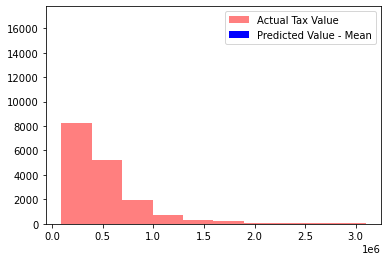

In [53]:
# plot to visualize actual v. predicted
# plot to visualize actual v. predicted

plt.hist(y_train.tax_value, color = 'red', alpha = .5, label = "Actual Tax Value")
plt.hist(y_train.y_pred_mean, bins=7, color = 'blue', rwidth=100, label = "Predicted Value - Mean")
# plt.hist(y_train.y_pred_median, bins=7, color = 'gold', alpha = .5, rwidth=100, label = "Predicted Value - Median")
plt.legend()
plt.show()


### ```Evaluate - OLS Model```

In [ ]:

#fitting the ols - model
ols_model = ols('tip ~ tax_value', data=df).fit()

# generate parameters, i.e. create model
#ols_model = ols('y ~ x', data=df).fit()

# compute predictions and add to original dataframe
df['yhat'] = ols_model.predict(df.total_bill)
df

ols_model.summary()


### ```Model Data - Explore```

####  Ordinary Lease Squares (OLS) Model

In [65]:
# make the model
lm = LinearRegression(normalize=True)

#fit the model to training data. 
lm.fit(X_train_scaled, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

In [66]:
#evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 8)

In [67]:
y_train.head()

,tax_value,tax_value_pred_lm
parcel_id,,
11640078,475281.000,1214672.621
10728405,605000.000,410135.000
17239776,542864.000,436444.289
11473641,120656.000,514999.269
12551066,234048.000,375864.114


In [48]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16944 entries, 11640078 to 12506634
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     16944 non-null  float64
 1   bathrooms    16944 non-null  float64
 2   age          16944 non-null  float64
 3   square_feet  16944 non-null  float64
 4   lot_size     16944 non-null  float64
 5   zip_code     16944 non-null  float64
 6   taxes        16944 non-null  float64
 7   fips         16944 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB


####  LassoLars Model

In [67]:
#create the model
lars = LassoLars(alpha = 1.0)

#fit the model to training data
lars.fit(X_train_scaled, y_train.tax_value)

# #predict train
# y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

# #evaluate: rmse
# rmse_train = mean_squared_error(y_train.tax_value,y_train.tax_value_pred_lars)**(1/2)

# #predict validate
# y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

#evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value,y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining\In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)

RMSE for Lasso + Lars
Training\In-Sample:   84454.37515086566 
Validation/Out-of-Sample:   85323.5998322027


#### TweedieRegressor (GLM - Generalized Linear Model)

In [68]:
#create the model object
glm = TweedieRegressor(power=1, alpha=0)

#fit the model to training data
glm.fit(X_train_scaled,y_train.tax_value)

#predict train
y_train['tax_value_pred_glm']=glm.predict(X_train_scaled)

#evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value,y_train.tax_value_pred_glm)**(1/2)

#predict validate
y_validate['tax_value_pred_glm']=glm.predict(X_validate_scaled)

#evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value,y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power = 1 & alpha = 0\nTraining/In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 8)

In [69]:
y_train.head()

,tax_value,tax_value_pred_lm,tax_value_pred_glm
parcel_id,,,
11640078,475281.000,1214672.621,1381808.886
10728405,605000.000,410135.000,407809.461
17239776,542864.000,436444.289,421591.981
11473641,120656.000,514999.269,479987.895
12551066,234048.000,375864.114,390583.705


In [70]:
r2_score(y_train.tax_value, y_train.tax_value_pred_lm)

0.371179057231505

### Polynomial Regression - Create Polynomial Features, Then Linear Regression

In [69]:
# make the polynomial fetures to get a new set of features
pf = PolynomialFeatures(degree=2)

#fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

#transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

# make the model
lm2 = LinearRegression(normalize=True)

#fit the model to training data. 
lm2.fit(X_train_degree2, y_train.tax_value)

# #predict train
# y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# # evaluate: RMSE
# rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# #predict validate
# y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training In-Sample:   80284.77961310698 
Validation/Out-of-Sample:   79525.92873817428


In [75]:
y_validate.head()


,tax_value,y_pred_mean,y_pred_median,tax_value_pred_lm,tax_value_pred_lars,tax_value_pred_glm,tax_value_pred_lm2
parcel_id,,,,,,,
11344899,568000.000,505045.807,399000.000,664242.749,664154.119,532915.199,665297.312
11855831,329844.000,505045.807,399000.000,404326.625,404215.020,380151.022,416692.888
13086537,194580.000,505045.807,399000.000,211884.731,212327.514,321889.209,208634.213
13858389,1072000.000,505045.807,399000.000,1006761.579,1006498.933,731763.945,1061249.001
14167439,636561.000,505045.807,399000.000,600549.631,601188.137,464123.117,634854.004


### ```Evaluate```

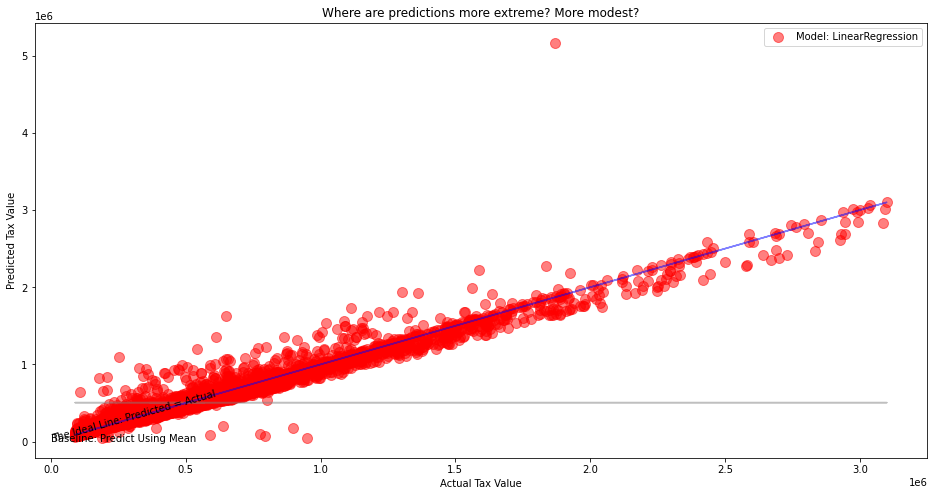

In [77]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.y_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
plt.show()

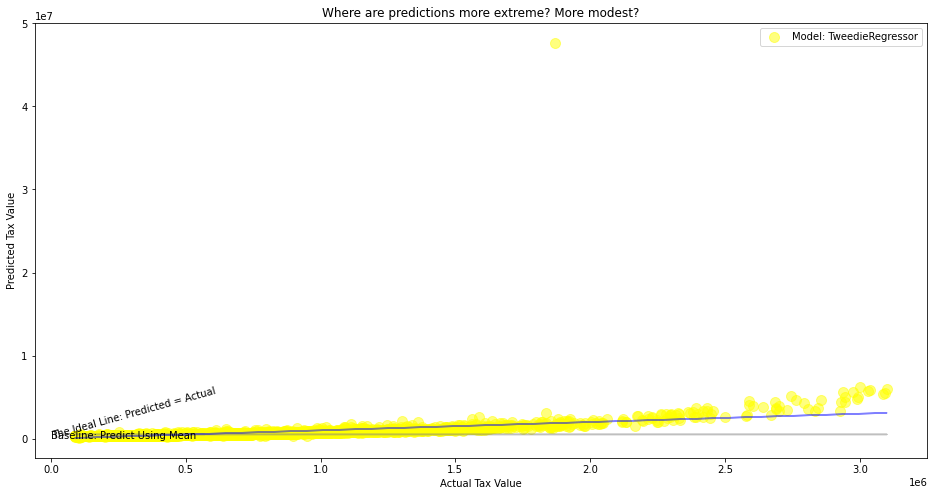

In [78]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.y_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
plt.show()

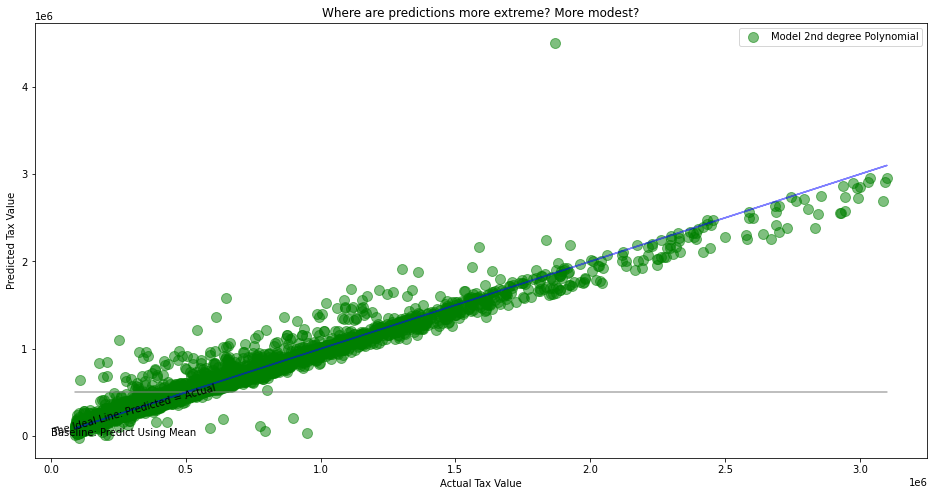

In [79]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.y_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
plt.show()

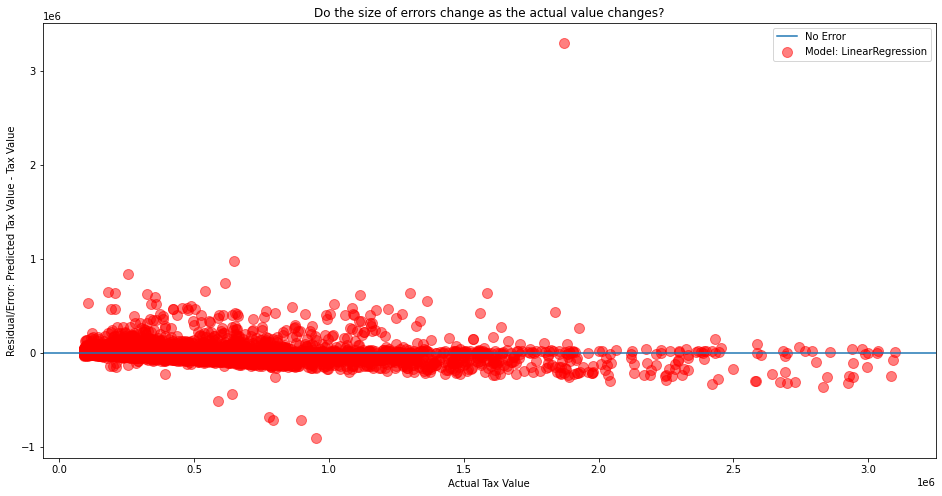

In [81]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()

In [116]:
y_validate[y_validate.tax_value_pred_glm - y_validate.tax_value > 4]



AttributeError: 'DataFrame' object has no attribute 'tax_value_pred_glm'

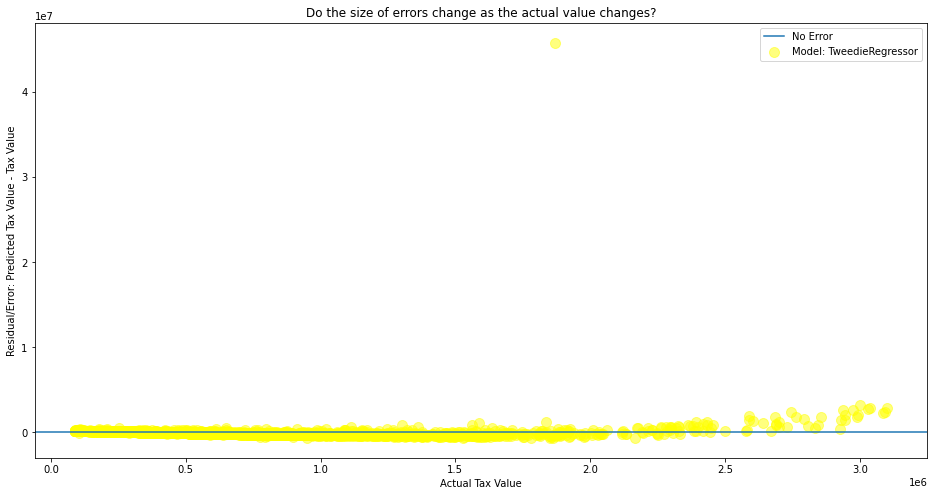

In [82]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()

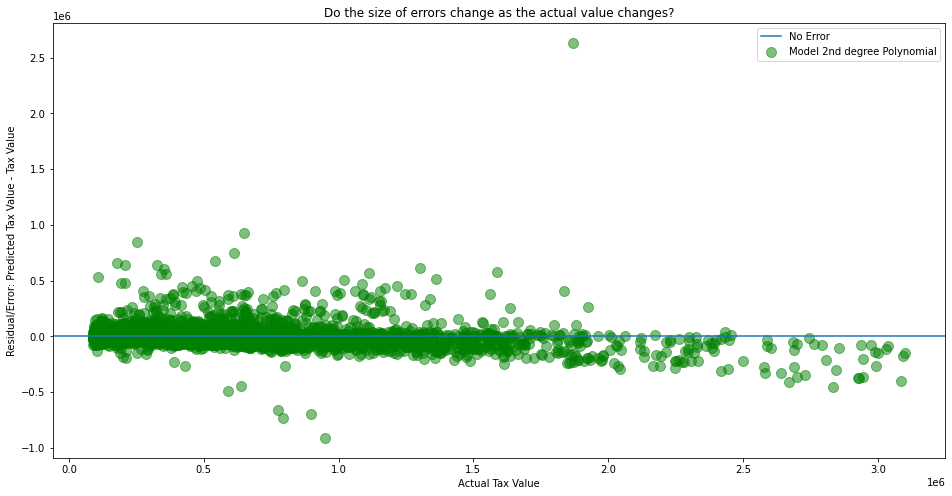

In [83]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2 - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()

### ```Feature Engineering```

In [49]:
X_train_scaled.shape

(16944, 8)

In [51]:

y_train = y_train.drop(columns=['y_pred_median', 'y_pred_mean', "tax_value_pred_lm"])
y_train

,tax_value
parcel_id,
11640078,475281.000
10728405,605000.000
17239776,542864.000
11473641,120656.000
12551066,234048.000
...,...
12242675,411241.000
11272474,225104.000
10756097,2195680.000


In [54]:
X_train_scaled = X_train_scaled.drop(columns=['taxes'])
X_train_scaled.head()

,bedrooms,bathrooms,age,square_feet,lot_size,zip_code,fips
11640078,0.500,1.000,0.464,0.608,0.004,0.076,0.000
10728405,0.333,0.200,0.406,0.160,0.001,0.264,0.000
17239776,0.333,0.200,0.377,0.192,0.001,0.833,1.000
11473641,0.333,0.200,0.529,0.193,0.001,0.089,0.000
12551066,0.333,0.200,0.457,0.122,0.000,0.193,0.000


In [121]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 2 features
f_selector = SelectKBest(f_regression, k=3)

# find the top 2 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
#get_support() produces an array of booleans, so we can filter out the column names that matter the most
feature_mask = f_selector.get_support()

# get list of top 2 features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
f_feature
print(f'The two best predictors, according to k best are: {f_feature}.')

ValueError: y should be a 1d array, got an array of shape (16944, 3) instead.

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 4)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

rfe_feature
print(f'The two best predictors, according to recursive feature elimination are: {rfe_feature}.')

The two best predictors, according to recursive feature elimination are: ['bedrooms', 'square_feet', 'lot_size', 'zip_code'].


In [62]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 2 features
f_selector = SelectKBest(f_regression, k=4)

# find the top kS X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
f_feature
print(f'The two best predictors, according to k best are: {f_feature}.')

The two best predictors, according to k best are: ['bedrooms', 'bathrooms', 'age', 'square_feet'].


# ```Distribution of Tax Rates by County```

In [82]:
df.head()


,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes
parcel_id,,,,,,,,,
11721753,2,3,94,1316,5672.000,6037,95997,205123.000,2627.480
11289917,2,3,47,1458,8284.000,6037,97318,136104.000,2319.900
11637029,2,3,37,1766,25082.000,6037,96086,810694.000,9407.010
14269464,3,4,14,2541,4975.000,6059,96958,880456.000,9819.720
11446756,2,3,62,1491,5000.000,6037,96162,107110.000,1399.270


In [83]:
df['tax_rate'] = round(((df.taxes / df.tax_value) * 100),2)
df.head()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes,tax_rate
parcel_id,,,,,,,,,,
11721753,2,3,94,1316,5672.000,6037,95997,205123.000,2627.480,1.280
11289917,2,3,47,1458,8284.000,6037,97318,136104.000,2319.900,1.700
11637029,2,3,37,1766,25082.000,6037,96086,810694.000,9407.010,1.160
14269464,3,4,14,2541,4975.000,6059,96958,880456.000,9819.720,1.120
11446756,2,3,62,1491,5000.000,6037,96162,107110.000,1399.270,1.310


In [84]:
df.describe()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes,tax_rate
count,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000,30259.000
mean,2.309,3.167,48.126,1843.995,30609.348,6047.488,96524.673,506419.954,6183.252,1.274
std,0.865,0.947,22.481,811.673,114494.717,20.048,404.214,399716.440,4651.652,0.280
min,1.000,1.000,1.000,700.000,236.000,6037.000,95982.000,90035.000,62.440,0.010
25%,2.000,3.000,31.000,1254.000,5854.500,6037.000,96204.000,248916.000,3256.365,1.170
50%,2.000,3.000,48.000,1638.000,7380.000,6037.000,96383.000,400941.000,4944.940,1.220
75%,3.000,4.000,63.000,2240.000,12455.500,6059.000,96982.000,624139.000,7460.365,1.310
max,6.000,7.000,139.000,5496.000,6971010.000,6111.000,97344.000,3100000.000,61992.630,18.260


In [87]:

# sns.displot(ventura, x="tax_rate")


grouped = df.groupby(df.fips)

Ventura = grouped.get_group(6111)

Ventura.head()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes,tax_rate
parcel_id,,,,,,,,,,
17165634,2,6,67,2526,6552.000,6111,97104,94344.000,1082.460,1.150
17059646,1,3,60,1396,20441.000,6111,97099,565000.000,6760.460,1.200
17222974,5,3,18,4361,1323788.000,6111,97118,1562700.000,17692.720,1.130
17294157,3,4,40,2846,8300.000,6111,96384,269273.000,3630.680,1.350
17290244,2,4,39,2542,47916.000,6111,96385,1090401.000,11660.160,1.070


In [88]:
Ventura.shape

(2211, 10)

In [89]:
Ventura.describe()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes,tax_rate
count,2211.000,2211.000,2211.000,2211.000,2211.000,2211.000,2211.000,2211.000,2211.000,2211.000
mean,2.334,3.599,39.626,2103.667,11969.212,6111.000,96907.042,522053.883,6005.779,1.162
std,0.764,0.813,18.086,833.191,32151.652,0.000,322.652,296744.925,3418.407,0.183
min,1.000,1.000,2.000,720.000,236.000,6111.000,96116.000,90206.000,62.440,0.010
25%,2.000,3.000,26.000,1467.500,6104.000,6111.000,96393.000,326818.000,3736.680,1.070
50%,2.000,4.000,40.000,1927.000,7419.000,6111.000,97094.000,462900.000,5222.220,1.120
75%,3.000,4.000,53.000,2560.000,10296.000,6111.000,97107.000,648031.000,7382.310,1.190
max,5.000,7.000,137.000,5443.000,1323788.000,6111.000,97119.000,3045749.000,32640.900,2.910


In [90]:
Ventura.value_counts("tax_rate", ascending = False)

tax_rate
1.070    244
1.060    235
1.080    135
1.050    117
1.170    102
        ... 
1.860      1
1.880      1
1.890      1
1.900      1
0.010      1
Length: 108, dtype: int64

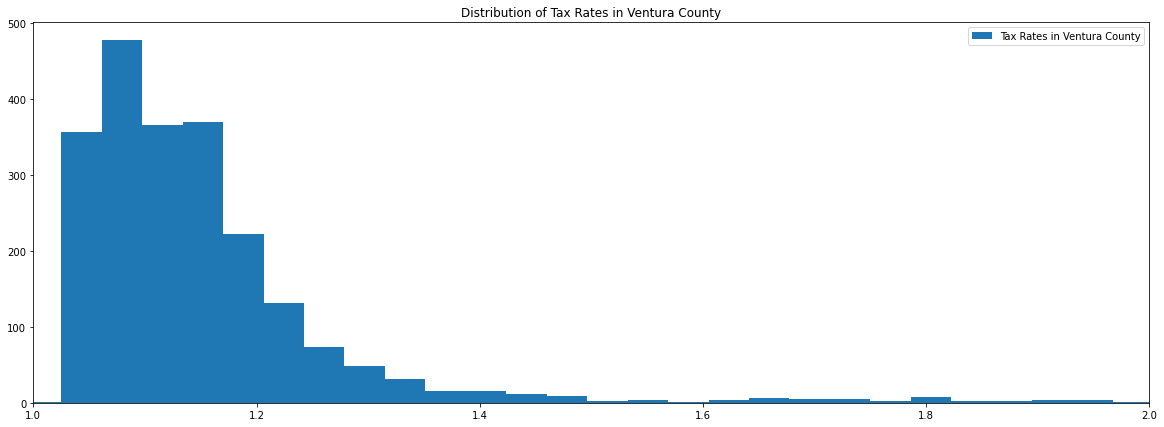

In [118]:
plt.figure(figsize=(20, 7))
plt.hist(Ventura.tax_rate, bins = 80, rwidth=600, label = "Tax Rates in Ventura County")
#plt.hist(y_train.y_pred_mean, bins=7, color = 'black', alpha = .5, rwidth=100, label = "Predicted Tax Value - Mean")
#plt.hist(y_train.y_pred_median, bins=7, color = 'gold', alpha = .5, rwidth=100, label = "Predicted Tax Value - Median")
plt.title("Distribution of Tax Rates in Ventura County")
plt.legend()
plt.xlim([1, 2])
# plt.xticks(np.arange(1, .5, 3)) 
plt.show()

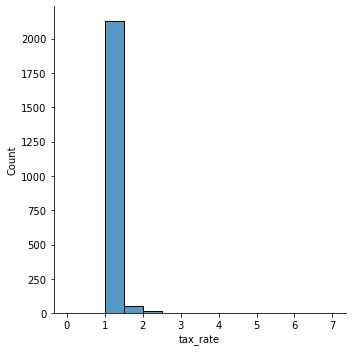

In [94]:
sns.displot(Ventura, x="tax_rate", bins=[0, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3,3.5, 4, 4.5, 5, 6, 7])

In [92]:
def remove_tax_value_outliers(df):
    # Calculate the interquartile range for your column

    q1, q3 = df.taxvaluedollarcnt.quantile([.25, .75])
    
    iqr = q3 - q1
    
    # Create variables holding upper and lower cutoff values using common formula. Tweak as you like.
    
    tax_upperbound = q3 + 3.5 * iqr
    
    #tax_lowerbound = q1 - 3 * iqr ==> The lowerbound is negative and since there are no negative values, 
    # there are no lowerbound outliers
    
    # Filter the column using variables and reassign to your dataframe.
    df = df[df.taxvaluedollarcnt < tax_upperbound]
    return df

remove_tax_value_outliers()

TypeError: remove_tax_value_outliers() missing 1 required positional argument: 'df'

In [99]:
df.value_counts('fips')

fips
6037    24224
6059     7717
6111     2415
dtype: int64

In [74]:
new = df.groupby(df.fips)
new

In [75]:
la=new.get_group(6037)
la.head()

,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes
parcel_id,,,,,,,,,
11721753,2,3,94,1316,5672.000,6037,95997,205123.000,2627.480
11289917,2,3,47,1458,8284.000,6037,97318,136104.000,2319.900
11637029,2,3,37,1766,25082.000,6037,96086,810694.000,9407.010
11446756,2,3,62,1491,5000.000,6037,96162,107110.000,1399.270
11389003,2,3,68,1650,7300.000,6037,96037,614000.000,7673.190


In [76]:
la.value_counts('tax_rate')

KeyError: 'tax_rate'

In [77]:
plt.hist(la.tax_rate, color = 'blue', bins = 20, rwidth=100,  range=[0,10], label = "Tax Rates in Los Angeles County")
# plt.hist(y_train.y_pred_mean, bins=7, color = 'black', alpha = .5, rwidth=100, label = "Predicted Tax Value - Mean")
# plt.hist(y_train.y_pred_median, bins=7, color = 'gold', alpha = .5, rwidth=100, label = "Predicted Tax Value - Median")
plt.title("Distribution of Tax Rates in Los Angeles County")
plt.legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'tax_rate'

In [78]:
sns.displot(la, x="tax_rate", bins=[0, 0.5, 1, 1.5, 2, 2.5, 3,3.5, 4, 4.5, 5, 6, 7])

ValueError: Could not interpret value `tax_rate` for parameter `x`

In [79]:
orange=new.get_group(6059)
orange.head()


,bathrooms,bedrooms,age,square_feet,lot_size,fips,zip_code,tax_value,taxes
parcel_id,,,,,,,,,
14269464,3,4,14,2541,4975.000,6059,96958,880456.000,9819.720
14236060,2,3,41,1668,6774.000,6059,97064,196483.000,2376.340
14365030,2,3,25,1653,3090.000,6059,96989,605000.000,6185.280
14008322,1,3,64,879,6000.000,6059,97048,141875.000,2015.780
13880422,2,3,54,1306,7300.000,6059,97021,203480.000,2543.860


In [80]:
plt.hist(orange.tax_rate, color = 'orange', bins = 4, rwidth=100,  range=[0,8], label = "Tax Rates in Orange County")
# plt.hist(y_train.y_pred_mean, bins=7, color = 'black', alpha = .5, rwidth=100, label = "Predicted Tax Value - Mean")
# plt.hist(y_train.y_pred_median, bins=7, color = 'gold', alpha = .5, rwidth=100, label = "Predicted Tax Value - Median")
plt.title("Distribution of Tax Rates in Orange County")
plt.legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'tax_rate'

In [81]:
sns.displot(orange, x="tax_rate", bins=[0, 0.5, 1, 1.5, 2, 2.5, 3,3.5, 4, 4.5, 5, 6, 7])

ValueError: Could not interpret value `tax_rate` for parameter `x`

In [141]:
plt.hist(Ventura.tax_rate, color = 'blue', bins = 200, rwidth=600,  range=[1,3], label = "Tax Rates in Ventura County")
plt.hist(la.tax_rate, color = 'orange', bins = 200, rwidth=600,  range=[1,3], label = "Tax Rates in Los Angeles County")
plt.hist(Orange.tax_rate, color = 'purple', bins = 200, rwidth=600,  range=[1,3], label = "Tax Rates in Orange County"
plt.title("Distribution of Tax Rates in Ventura County")
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-141-c0aaf000612a>, line 4)

In [142]:
cat_vars = ['fips']
quant_vars = ['tax_amount']
explore.explore_univariate(df, cat_vars, quant_vars)

NameError: name 'explore' is not defined

### ```Model Data with Engineered Features```

####  Ordinary Lease Squares (OLS) Model

In [46]:
# make the model
lm = LinearRegression(normalize=True)

#fit the model to training data. 
lm.fit(X_train_scaled, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

In [47]:
#evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)

RMSE for OLS using LinearRegression
Training In-Sample:   84453.06086495012 
Validation/Out-of-Sample:   85306.2768236501


In [48]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16944 entries, 11640078 to 12506634
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     16944 non-null  float64
 1   bathrooms    16944 non-null  float64
 2   age          16944 non-null  float64
 3   square_feet  16944 non-null  float64
 4   lot_size     16944 non-null  float64
 5   zip_code     16944 non-null  float64
 6   taxes        16944 non-null  float64
 7   fips         16944 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB


####  LassoLars Model

In [67]:
#create the model
lars = LassoLars(alpha = 1.0)

#fit the model to training data
lars.fit(X_train_scaled, y_train.tax_value)

# #predict train
# y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

# #evaluate: rmse
# rmse_train = mean_squared_error(y_train.tax_value,y_train.tax_value_pred_lars)**(1/2)

# #predict validate
# y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

#evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value,y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining\In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)

RMSE for Lasso + Lars
Training\In-Sample:   84454.37515086566 
Validation/Out-of-Sample:   85323.5998322027


#### TweedieRegressor (GLM - Generalized Linear Model)

In [68]:
#create the model object
glm = TweedieRegressor(power=1, alpha=0)

#fit the model to training data
glm.fit(X_train_scaled,y_train.tax_value)

# #predict train
# y_train['tax_value_pred_glm']=glm.predict(X_train_scaled)

# #evaluate: rmse
# rmse_train = mean_squared_error(y_train.tax_value,y_train.tax_value_pred_glm)**(1/2)

# #predict validate
# y_validate['tax_value_pred_glm']=glm.predict(X_validate_scaled)

#evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value,y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power = 1 & alpha = 0\nTraining/In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)

RMSE for GLM using Tweedie, power = 1 & alpha = 0
Training/In-Sample:   351997.5775712004 
Validation/Out-of-Sample:   572328.4341676913


### Polynomial Regression - Create Polynomial Features, Then Linear Regression

In [69]:
# make the polynomial fetures to get a new set of features
pf = PolynomialFeatures(degree=2)

#fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

#transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

# make the model
lm2 = LinearRegression(normalize=True)

#fit the model to training data. 
lm2.fit(X_train_degree2, y_train.tax_value)

# #predict train
# y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# # evaluate: RMSE
# rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# #predict validate
# y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining In-Sample:  ", rmse_train, "\nValidation/Out-of-Sample:  ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training In-Sample:   80284.77961310698 
Validation/Out-of-Sample:   79525.92873817428


In [75]:
y_validate.head()


,tax_value,y_pred_mean,y_pred_median,tax_value_pred_lm,tax_value_pred_lars,tax_value_pred_glm,tax_value_pred_lm2
parcel_id,,,,,,,
11344899,568000.000,505045.807,399000.000,664242.749,664154.119,532915.199,665297.312
11855831,329844.000,505045.807,399000.000,404326.625,404215.020,380151.022,416692.888
13086537,194580.000,505045.807,399000.000,211884.731,212327.514,321889.209,208634.213
13858389,1072000.000,505045.807,399000.000,1006761.579,1006498.933,731763.945,1061249.001
14167439,636561.000,505045.807,399000.000,600549.631,601188.137,464123.117,634854.004


### ```Evaluate```

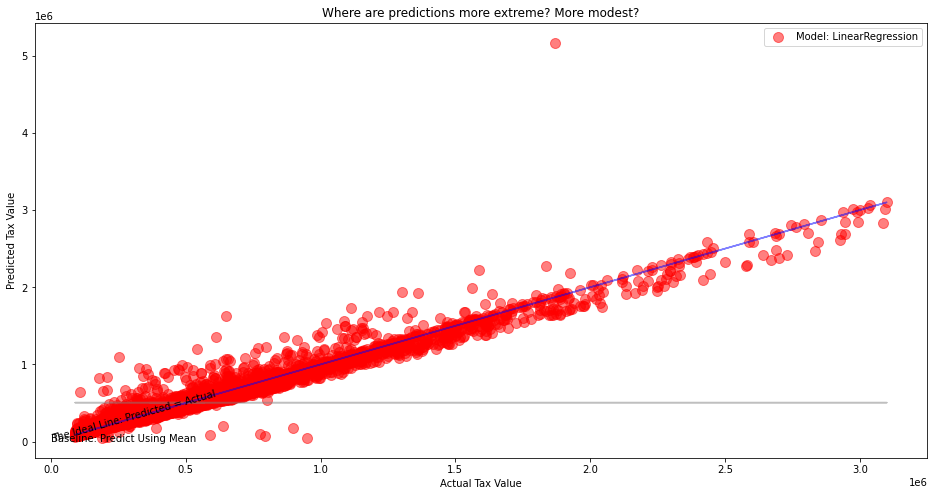

In [77]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.y_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
plt.show()

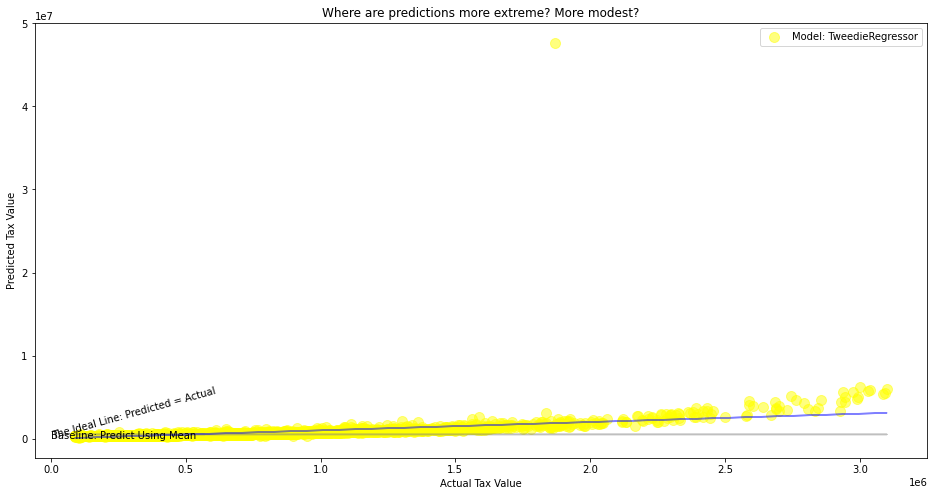

In [78]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.y_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
plt.show()

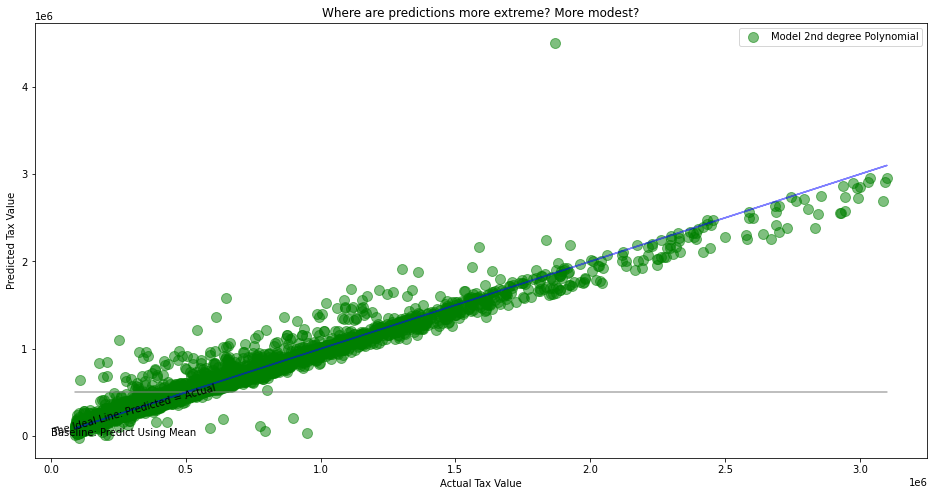

In [79]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.y_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
plt.show()

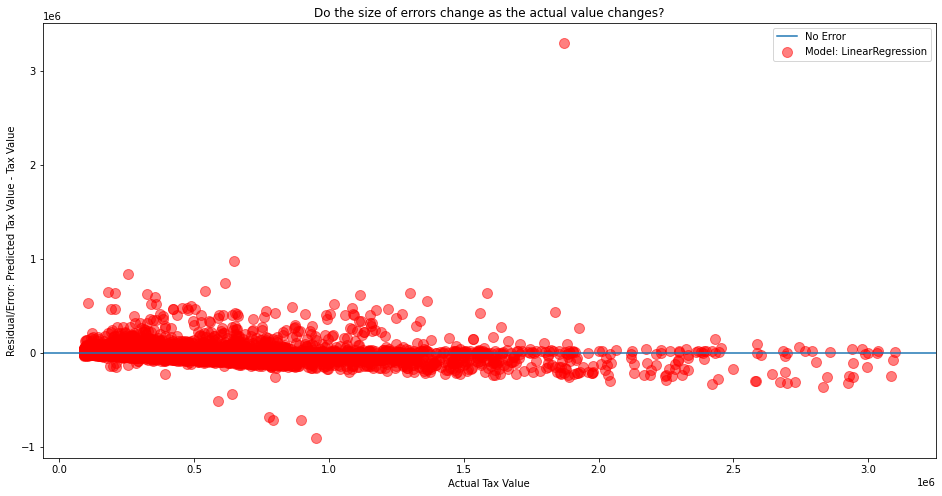

In [81]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()

AttributeError: 'DataFrame' object has no attribute 'tax_value_pred_glm'

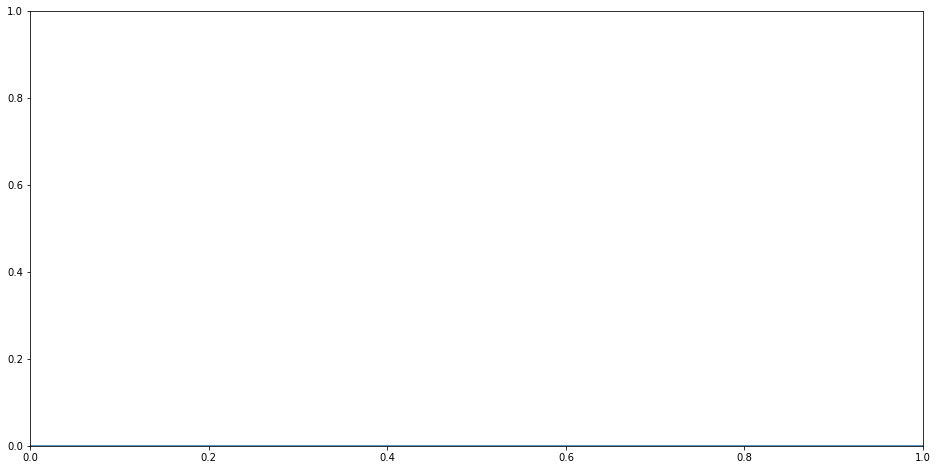

In [120]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()

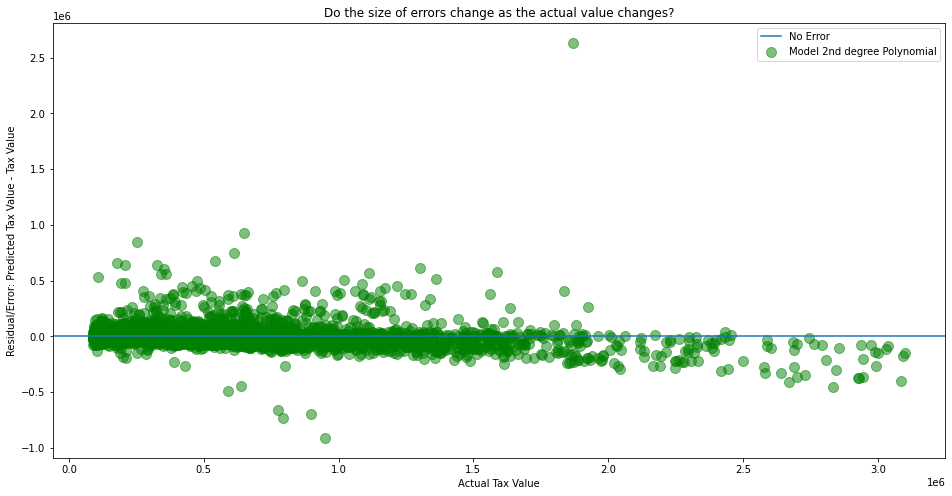

In [83]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2 - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()